# Predicting Football Results with Statistical Modelling: Dixon-Coles and Time-Weighting

https://github.com/dashee87/blogScripts/blob/master/Jupyter/2018-09-13-predicting-football-results-with-statistical-modelling-dixon-coles-and-time-weighting.ipynb

# https://fivethirtyeight.com/methodology/how-our-club-soccer-predictions-work/

## Data

We'll initially pull the match results for the 2022/23 season from [football-data.co.uk](football-data.co.uk). This code is pretty much the same as last time.

In [10]:
# https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-06-04-predicting-football-results-with-statistical-modelling.ipynb

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import poisson,skellam
from scipy.optimize import minimize

sa_2223 = pd.read_csv("https://www.football-data.co.uk/mmz4281/2223/I1.csv")
sa_2223 = sa_2223[['HomeTeam','AwayTeam','FTHG','FTAG']]
sa_2223 = sa_2223.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
sa_2223.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals
0,Milan,Udinese,4,2
1,Sampdoria,Atalanta,0,2
2,Lecce,Inter,1,2
3,Monza,Torino,1,2
4,Fiorentina,Cremonese,3,2


## Basic Poisson Model

I won't spend too long on this model, as it was the subject of the [previous post](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/). 

Essentially, you treat the number of goals scored by each team as two independent Poisson distributions (henceforth called the Basic Poisson (BP) model). The shape of each distribution is determined by the average number of goals scored by that team. A little reminder on the mathematical definition of the Poisson distribution:

$$
P\left( x \right) = \frac{e^{-\lambda} \lambda ^x }{x!}, \lambda>0
$$

In our case, $\lambda$ represents the team's average or expected goal scoring rate. The Poisson distribution is a decent approximation of a team's scoring frequency. All of the model's discussed here agree on this point; the disagreement centres on how to calculate $\lambda_{home}$ and $\lambda_{away}$.


- **$\lambda_{home}$**: This is the average number of goals the home team is expected to score in a match. It's calculated from historical data on how many goals the team typically scores when playing at home.
- **$\lambda_{away}$**: Similarly, this is the average number of goals the away team is expected to score, based on their historical performance in away games.

While there's general agreement on using the Poisson distribution to model goal-scoring, the debate often lies in how to best estimate $\lambda_{home}$ and $\lambda_{away}$ — the average scoring rates for the home and away teams, respectively. This estimation can be influenced by many factors, including:

- **Team Strength**: How good the teams are offensively and defensively.
- **Recent Form**: How well the teams have been playing recently.
- **Head-to-Head History**: Historical performance in matches between the two teams.
- **Player Availability**: Injuries, suspensions, and other factors affecting team composition.

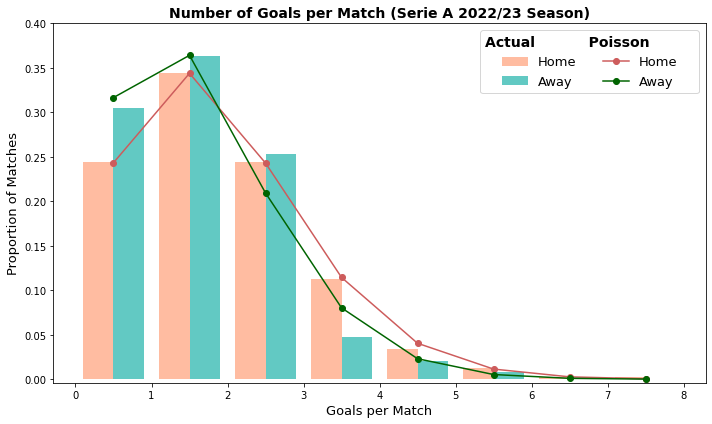

In [11]:
# construct Poisson for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(i, sa_2223[['HomeGoals', 'AwayGoals']].mean(numeric_only=True)[j]) for i in range(8)] for j in range(2)])
# Set the figure size for a larger plot
plt.figure(figsize=(10, 6))  # Adjust the size as needed

# Plot histogram of actual goals
plt.hist(sa_2223[['HomeGoals', 'AwayGoals']].values, bins=range(9), 
         alpha=0.7, label=['Home', 'Away'], density=True, color=["#FFA07A", "#20B2AA"])

# Add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#006400')

# Customize the legend
leg = plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Actual           Poisson         ", prop = {'size':'14', 'weight':'bold'})

# Set ticks, labels, and title
plt.xticks([i for i in range(9)], [i for i in range(9)])
plt.xlabel("Goals per Match", size=13)
plt.ylabel("Proportion of Matches", size=13)
plt.title("Number of Goals per Match (Serie A 2022/23 Season)", size=14, fontweight='bold')
plt.ylim([-0.004, 0.4])

# Tight layout for a neat presentation
plt.tight_layout()

# Save the figure as a PDF
plt.savefig('goals_per_match_serie_a_2223.pdf', bbox_inches='tight')

# Display the plot
plt.show()

We can formulate the model in mathematical terms:
$$
P\left(X_{i,j} = x, Y_{j,i} = y \right) = \frac{e^{-\lambda} \lambda^x }{x!} \frac{e^{-\mu} \mu^y }{y!}
\\ \text{where } \quad \lambda = \alpha_i \beta_j \gamma \quad \mu = \alpha_j \beta_i
$$


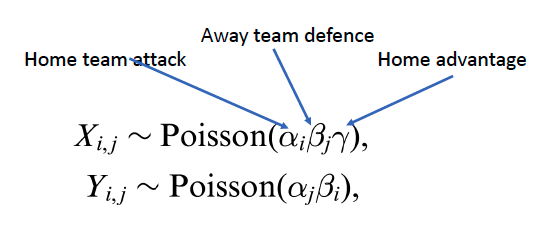

In this equation, $i$ and $j$ refer to the home and away teams, respectively; $\alpha$ and $\beta$ denote each team's attack and defensive strength, respectively, while $\gamma$ represents the home advantage factor. So, we need to calculate $\alpha$ and $\beta$ for each team, as well as $\gamma$ (the home field advantage term- it's the same value for every team). 

## Building A Model

In [12]:
# importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf

goal_model_data = pd.concat([sa_2223[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           sa_2223[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()

poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  760
Model:                            GLM   Df Residuals:                      720
Model Family:                 Poisson   Df Model:                           39
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1028.8
Date:                Thu, 22 Feb 2024   Deviance:                       735.38
Time:                        09:17:32   Pearson chi2:                     635.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1741
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.4509      0.196      2.301      0.021       0.067       0.835
team[T.Bologna]            -0.2190      0.185     -1.185      0.236      -0.581       0.143
team[T.Cremonese]          -0.5851      0.208     -2.819      0.005      -0.992      -0.178
team[T.Empoli]             -0.5793      0.206     -2.817      0.005      -0.982      -0.176
team[T.Fiorentina]         -0.2256      0.185     -1.221      0.222      -0.588       0.137
team[T.Inter]               0.0667      0.171      0.389      0.697      -0.269       0.402
team[T.Juventus]           -0.1812      0.182     -0.996      0.319      -0.538       0.175
team[T.Lazio]              -0.1153      0.179     -0.645      0.519      -0.465       0.235
team[T.Lecce]              -0.6971      0.213     -3.266      0.001      -1.116      -0.279
team[T.Milan]              -0.0364      0.176     -0.207      0.836      -0.381       0.308
team[T.Monza]              -0.3151      0.190     -1.659      0.097      -0.688       0.057
team[T.Napoli]              0.1326      0.168      0.789      0.430      -0.197       0.462
team[T.Roma]               -0.2894      0.188     -1.541      0.123      -0.657       0.079
team[T.Salernitana]        -0.3042      0.190     -1.601      0.109      -0.677       0.068
team[T.Sampdoria]          -0.9894      0.239     -4.146      0.000      -1.457      -0.522
team[T.Sassuolo]           -0.3264      0.191     -1.707      0.088      -0.701       0.048
team[T.Spezia]             -0.7426      0.218     -3.406      0.001      -1.170      -0.315
team[T.Torino]             -0.4609      0.198     -2.332      0.020      -0.848      -0.073
team[T.Udinese]            -0.3406      0.191     -1.782      0.075      -0.715       0.034
team[T.Verona]             -0.7459      0.218     -3.421      0.001      -1.173      -0.319
opponent[T.Bologna]         0.0064      0.203      0.031      0.975      -0.392       0.405
opponent[T.Cremonese]       0.3311      0.188      1.759      0.079      -0.038       0.700
opponent[T.Empoli]         -0.0109      0.203     -0.054      0.957      -0.410       0.388
opponent[T.Fiorentina]     -0.1246      0.210     -0.593      0.554      -0.537       0.288
opponent[T.Inter]          -0.1285      0.212     -0.607      0.544      -0.543       0.286
opponent[T.Juventus]       -0.3867      0.226     -1.708      0.088      -0.831       0.057
opponent[T.Lazio]          -0.4779      0.233     -2.051      0.040      -0.935      -0.021
opponent[T.Lecce]          -0.0785      0.207     -0.380      0.704      -0.483       0.326
opponent[T.Milan]          -0.1126      0.210     -0.535      0.592      -0.525       0.300
opponent[T.Monza]           0.0605      0.201      0.302      0.763      -0.332       0.454
opponent[T.Napoli]         -0.5286      0.238  

## Making Predictions

Let's start making some predictions about future games. 

We simply pass our teams into poisson_model and it'll return the expected average number of goals for your team (we need to run it twice- we calculate the expected average number of goals for each team separately).

So let's see how many goals we expect Milan and Atalanta to score.

### Milan vs Atalanta 

In [13]:
# predicts the number of goals Milan is expected to score when playing against Atalanta at home
poisson_model.predict(pd.DataFrame(data={'team': 'Milan', 'opponent': 'Atalanta',
                                       'home':1},index=[1]))

1    1.860068
dtype: float64

In [14]:
# predicts how many goals Atalanta might score when they are away against Milan
poisson_model.predict(pd.DataFrame(data={'team': 'Atalanta', 'opponent': 'Milan',
                                       'home':0},index=[1]))

1    1.402626
dtype: float64

Here our model predicts that Milan would be expected to score 1.86 goals against Atalanta, while Atalanta is expected to score 1.40 goals. 

In [15]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    # predicts the number of goals homeTeam is expected to score when playing against awayTeam
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    # predicts how many goals awayTeam might score when they are against homeTeam
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    # Calculating the Poisson Distribution for Predicted Averages
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    # Calculating the Match Outcome Probabilities
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

In [16]:
mil_ata = simulate_match(poisson_model, 'Milan', 'Atalanta', max_goals=10)

In [17]:
mil_ata[0:5, 0:5]

array([[0.03828509, 0.05369968, 0.03766029, 0.01760777, 0.00617428],
       [0.07121288, 0.09988507, 0.07005072, 0.03275166, 0.01148459],
       [0.06623041, 0.09289653, 0.06514956, 0.03046017, 0.01068106],
       [0.04106437, 0.05759796, 0.04039421, 0.018886  , 0.0066225 ],
       [0.01909563, 0.02678404, 0.018784  , 0.00878231, 0.00307958]])

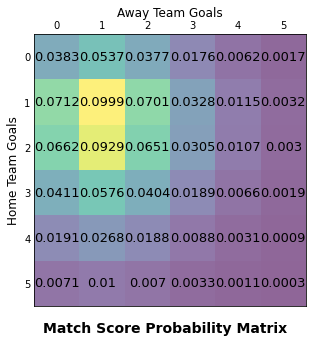

In [34]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np

def display_match_matrix(matrix, colour_matrix, colour_map, subtitle="", heatmap=False, alpha=0.8):
    fig, ax1 = plt.subplots(1, figsize=(5, 5))
    if heatmap:
        # Display the matrix as a heatmap
        ax1.matshow(matrix, alpha=alpha)
    else:
        # Display the matrix with specified colours
        ax1.matshow(colour_matrix, cmap=colour_map, alpha=alpha)
    ax1.tick_params(axis='both', which='both', length=0)
    ax1.grid(which='major', axis='both', linestyle='')
    ax1.set_xlabel('Away Team Goals', fontsize=12)
    ax1.set_ylabel('Home Team Goals', fontsize=12)
    ax1.xaxis.set_label_position('top')
    
    nrows, ncols = matrix.shape
    for i in range(nrows):
        for j in range(ncols):
            c = matrix[i, j]
            ax1.text(j, i, str(round(c, 4)), va='center', ha='center', size=13)
    
    plt.figtext(0.5, 0.05, subtitle, ha='center', fontsize=14, fontweight='bold')
    plt.show()

matrix = simulate_match(poisson_model, 'Milan', 'Atalanta', max_goals=5)
display_match_matrix(matrix, matrix, ListedColormap(['w']), heatmap=True, alpha=0.6, subtitle="Match Score Probability Matrix")


The Matrix displays the heatmap showing the probabilities of all possible scorelines between Milan and Atalanta.

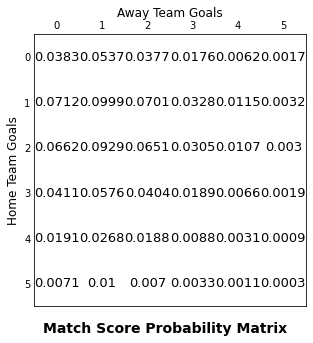

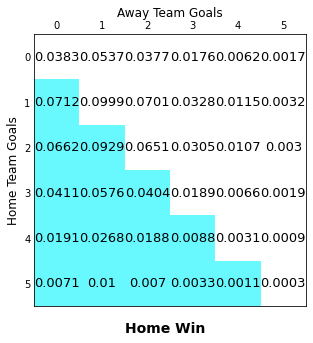

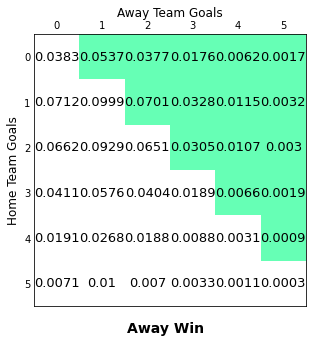

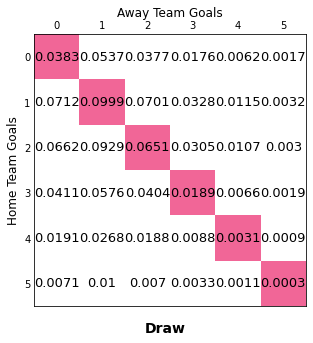

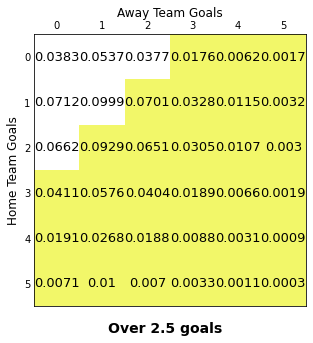

In [47]:
def matrix_gif(matrix, colour_matrix, colour_map, subtitle="", heatmap=False, alpha=0.8):
    fig, ax1 = plt.subplots(1, figsize=(5,5))
    if heatmap:
        ax1.matshow(matrix, alpha=alpha)
    else:
        ax1.matshow(colour_matrix, cmap=colour_map, alpha=alpha)
    ax1.tick_params(axis=u'both', which=u'both',length=0)
    ax1.grid(which='major', axis='both', linestyle='')
    ax1.set_xlabel('Away Team Goals', fontsize=12)
    ax1.set_ylabel('Home Team Goals', fontsize=12)
    ax1.xaxis.set_label_position('top')
    nrows, ncols = matrix.shape
    for i in range(nrows):
        for j in range(ncols):
            c = matrix[i][j]
            ax1.text(j, i, str(round(c,4)), va='center', ha='center', size=13)
    plt.figtext(0.5, 0.05, subtitle, horizontalalignment='center',
                fontsize=14, multialignment='left', fontweight='bold')
    return fig

cmap = ListedColormap(['w', '#04f5ff', '#00ff85', '#e90052'])
matrix = simulate_match(poisson_model, 'Milan', 'Atalanta', max_goals=5)
matn = len(matrix)
matrix_gif(matrix, matrix, ListedColormap(['w']), heatmap=True, 
           alpha=0.6, subtitle="Match Score Probability Matrix").savefig("match_matrix_0.png")
plt.close()
for t,(mat,colour,subtitle) in enumerate(zip([np.zeros((matn, matn)), np.tril(np.ones((matn,matn)),-1),
                            np.triu(np.ones((matn,matn))*2,1), np.diag([3]*matn),
                                             np.array([0 if i+j<3 else 1 for i in range(matn) for j in range(matn)]).reshape(matn,matn)],
                          ['w', '#04f5ff', '#00ff85', '#e90052','#EAF205'],
                                   ['Match Score Probability Matrix', 'Home Win', 'Away Win', 'Draw', 'Over 2.5 goals'])):
    matrix_gif(matrix, mat, ListedColormap(['w'] + [colour]), heatmap=False, 
               alpha=0.6, subtitle=subtitle).savefig("match_matrix_{}.png".format(t+1))
    #plt.close()

First [published by Maher in 1982](http://www.90minut.pl/misc/maher.pdf), the BP model still serves a good starting point from which you can add features that more closely reflect the reality. That brings us onto the Dixon Coles (DC) model.

## Dixon-Coles Model

In their 1997 paper, Mark Dixon and Stuart Coles proposed two specific improvements to the BP model:
* **Introduce an interaction term to correct underestimated frequency of low scoring matches**
* **Apply time decay component so that recent matches are weighted more strongly**

The authors claim that low score results (0-0, 1-0, 0-1 and 1-1) are inherently under-reported by the BP model. In the paper, they provide some analysis that supports their case- though I wouldn't call their approach particularly rigorous. 

In [67]:
def poiss_actual_diff(football_url, max_goals):
    sa_2223 = pd.read_csv(football_url)
    sa_2223 = sa_2223[['HomeTeam','AwayTeam','FTHG','FTAG']]
    sa_2223 = sa_2223.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals)] \
                 for team_avg in [sa_2223['HomeGoals'].mean(), sa_2223['AwayGoals'].mean()]]
    return np.outer(np.array(team_pred[0]), np.array(team_pred[1])) - \
        np.array([sum((sa_2223['HomeGoals']==i) & (sa_2223['AwayGoals']==j)) 
                  for i in range(max_goals) for j in range(max_goals)]).reshape((6,6))/len(sa_2223)

In [68]:
# url example for 22/23 season: https://www.football-data.co.uk/mmz4281/2223/I1.csv

year_arrays = []
for year in range(2005,2023):
    year_arrays.append(poiss_actual_diff("https://www.football-data.co.uk/mmz4281/{}{}/I1.csv".format(
        str(year)[-2:], str(year+1)[-2:]),6))

In [69]:
len(year_arrays)

18

The matrix below shows the average difference between actual and model predicted scorelines for the 2005/06 season all the way up to the 2022/2023 season. Green cells imply the model underestimated those scorelines, while red cells suggest overestimation- the colour strength indicates the level of disagreement.

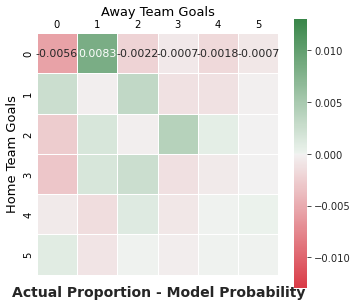

In [70]:
cmap = sns.diverging_palette(10, 133, as_cmap=True)

fig, ax = plt.subplots(figsize=(5,5))  
with sns.axes_style("white"):
    ax = sns.heatmap(np.mean(year_arrays, axis=0), annot=True, fmt='.4f', cmap=cmap, vmin=-0.013, vmax=.013, center=0.00,
                square=True, linewidths=.5, annot_kws={"size": 11}, cbar_kws={"shrink": .8})
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.grid(which='major', axis='both', linestyle='')
    ax.set_xlabel('Away Team Goals', fontsize=13)
    ax.set_ylabel('Home Team Goals', fontsize=13)
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('top')
    plt.figtext(0.45, 0.1, 'Actual Proportion - Model Probability', horizontalalignment='center',
                fontsize=14, multialignment='left', fontweight='bold')
plt.tight_layout()
plt.show()

There does seem to be an issue around low scoring draws, though it is less apparent with 1-0 and 0-1 results. The Dixon-Coles (DC) model applies a correction to the BP model. It can be written in these mathematical terms:

$$
P\left(X_{i,j} = x, Y_{j,i} = y \right) = \tau_{\lambda, \mu}(x) \frac{e^{-\lambda} \lambda^x }{x!} \frac{e^{-\mu} \mu^y }{y!}
\\ \text{where } \quad \lambda = \alpha_i \beta_j \gamma \quad \mu = \alpha_j \beta_i
\\
\tau_{\lambda, \mu}(x, y) =
  \begin{cases}
                                   1 - \lambda \mu \rho & \text{if $x = y = 0$} \\
                                   1 - \lambda \rho & \text{if $x=0$, $y=1$} \\
                                   1 + \mu \rho & \text{if $x=0$, $y=1$} \\
                                   1 - \rho & \text{if $x = y = 1$} \\
                                   1 & \text{otherwise} \\
  \end{cases}
$$

### **Key Features of the Dixon-Coles Model:**
[Modelling Association Football Scores and Inefficiencies in the Football Betting Market](https://www.jstor.org/stable/2986290)

- **Adjustment for Low Scoring Matches:** The model introduces a correction factor to the Poisson distribution to better predict the occurrence of low-scoring games (e.g., 0-0 draws), which the basic Poisson model tends to underestimate.

- **Team-Specific Parameters:** It incorporates team-specific attack and defense parameters, along with a home-field advantage parameter, to more accurately reflect the strengths and weaknesses of each team.

- **Tau Parameter:** A key innovation of the Dixon-Coles model is the introduction of the tau $(\tau)$ parameter, which adjusts the expected number of goals to account for the interaction between the attacking strength of one team and the defensive strength of the opponent. This adjustment is particularly significant in matches where a strong attack meets a strong defense, or vice versa.

The key difference over the BP model is the addition of the $\tau$ (tau) function. It is highly dependent on the $\rho$ (rho) parameter, which controls the strength of the correction (note: setting $\rho$=0 equates to the standard BP model). We can easily convert $\tau_{\lambda, \mu}(x, y)$ to Python code.

In [18]:
def rho_correction(x, y, lambda_x, mu_y, rho):
    if x==0 and y==0:
        return 1- (lambda_x * mu_y * rho)
    elif x==0 and y==1:
        return 1 + (lambda_x * rho)
    elif x==1 and y==0:
        return 1 + (mu_y * rho)
    elif x==1 and y==1:
        return 1 - rho
    else:
        return 1.0

When creating a more complex model to predict football match outcomes, like the number of goals scored by each team, we need to dive deeper into the mathematics behind statistical modeling. This involves using a method known as [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) (MLE). MLE helps us find the best parameters (coefficients) for our model based on the actual match data we have.

### Understanding Maximum Likelihood Estimation (MLE)

- **What is MLE?** Maximum Likelihood Estimation is a **statistical method used to estimate the parameters of a model**. The goal is to find the set of parameters that makes the observed data most likely to occur.
- **Why MLE?** We use MLE because it's a powerful way to account for how different factors (like team strengths and home advantage) influence the number of goals scored in a match. It's especially useful when the relationship between these factors and outcomes is complex.

### The Likelihood Function

$$
L(\alpha_i, \beta_i, \rho, \gamma, i=1,\dots,n) = \prod_{k=1}^{N} \tau_{\lambda_k,\mu_k}(x_k, y_k) \ \frac{e^{-\lambda} \lambda^{x_k} }{x_k!} \frac{e^{-\mu} \mu^{y_k} }{y_k!}
\\ \text{where } \quad \lambda_k = \alpha_{i(k)} \beta_{j(k)} \gamma \quad \mu_k = \alpha_{j(k)} \beta_{i(k)}
$$

When predicting football scores, we're interested in a specific likelihood function. This function calculates the probability of observing the actual match scores given our model's parameters. Here's a breakdown of the key components:

- In this equation, $i(k)$ and $j(k)$ respectively denote the indices of the home and away teams in match $k$. 
- **Matches Indexed**: We look at each match one by one, indexed from $k=1$ to $k=N$, where $N$ is the total number of matches.
- **Scores**: For each match $k$, we have the actual scores ($x_k$, $y_k$), where $x_k$ is the number of goals scored by the home team and $y_k$ by the away team.
- **Parameters**: $\alpha_i$ and $\beta_i$ represent the attacking and defensive strengths of team $i$, $\rho$ accounts for the interaction between the teams' attack and defense, and $\gamma$ represents the home team advantage.

### The Formula

- **Goal Rates ($\lambda_k$ and $\mu_k$)**: For each match, we calculate the expected goal rates for the home ($\lambda_k$) and away ($\mu_k$) teams based on our model's parameters. These rates depend on the teams' attacking and defensive strengths, as well as the home advantage.
- **Probability of Scores**: The likelihood of observing the actual scores is calculated using the Poisson distribution formula, adjusted for the expected goal rates.

### Maximizing the Log-Likelihood

- **Why Log-Likelihood?** We maximize the log of the likelihood function instead of the likelihood itself because it simplifies the calculations, improves numerical stability, and all without changing which parameters are considered the best (since the logarithm is a strictly increasing function).
- **Logarithmic Properties**: We leverage the property that $\log(a \cdot b) = \log(a) + \log(b)$ to transform the product of probabilities into a sum, making it easier to work with.

### Python Implementation

In [19]:
def dc_log_like(x, y, alpha_x, beta_x, alpha_y, beta_y, rho, gamma):
    lambda_x, mu_y = np.exp(alpha_x + beta_y + gamma), np.exp(alpha_y + beta_x) 
    return (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) + 
            np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))

`dc_log_like` is a function that applies the principles of Maximum Likelihood Estimation to find the best-fitting parameters for a model predicting football match scores.
This function calculates the **[log-likelihood](https://en.wikipedia.org/wiki/Likelihood_function)** of observing a given match outcome (the number of goals scored by the home and away teams) **based on certain parameters**. Let's break down the function and its components for clarity:

### Function Purpose and Parameters

- **Purpose**: The `dc_log_like` function calculates the log-likelihood, which **is a measure used to evaluate how well our model's parameters fit the actual match data**.
- **Parameters**:
  - `x`, `y`: The actual number of goals scored by the home and away teams, respectively, in a given match.
  - `alpha_x`, `beta_x`: Parameters representing the attacking strength of the home team and the defensive strength of the away team, respectively.
  - `alpha_y`, `beta_y`: Parameters representing the attacking strength of the away team and the defensive strength of the home team, respectively.
  - `rho`: A parameter that adjusts for the correlation between the home and away teams' goal-scoring processes.
  - `gamma`: A parameter representing the home team advantage.

### Transformations of $\lambda$ and $\mu$

- **$\lambda$ and $\mu$ Calculation**: The function transforms $\lambda$ and $\mu$, the expected number of goals to be scored by the home and away teams, using the exponential function. This ensures that $\lambda$ and $\mu$ are always positive, which is a requirement for the Poisson distribution used to model goal-scoring.
  - $\lambda = \exp(\alpha_i + \beta_j + \gamma)$: <font color="green">Expected goals for the home team</font>, combining the home team's attack strength, away team's defense strength, and home advantage.
  - $\mu = \exp(\alpha_j + \beta_i)$: <font color="red">Expected goals for the away team</font>, combining the away team's attack strength and home team's defense strength.

### Calculating Log-Likelihood

- The function calculates the log-likelihood for a match outcome by summing three components:
  1. **`rho_correction`**: A term that adjusts the log-likelihood based on the correlation between the home and away teams' scoring, ensuring the model accounts for interactions between team strengths.
  2. **Poisson PMF for Home Goals (`x`)**: The log of the probability mass function (PMF) of the Poisson distribution for the home team's goals, based on $\lambda$.
  3. **Poisson PMF for Away Goals (`y`)**: The log of the PMF of the Poisson distribution for the away team's goals, based on $\mu$.

### Why Use Exponential Transformations?

- The exponential transformation of $\lambda$ and $\mu$ through the parameters ($\alpha$ and $\beta$ for attacking and defensive strengths, and $\gamma$ for home advantage) guarantees that the expected goals ($\lambda$ and $\mu$) are always positive. This is crucial because the Poisson distribution cannot handle non-positive rates ($\lambda$ and $\mu$), and having them ensures the model's compatibility with the underlying statistical assumptions.
- This approach also facilitates the convergence of the optimization algorithm used to maximize the log-likelihood function, as it operates within the valid domain of the Poisson distribution.
- This approach directly applies the properties of logarithms to transform the product of probabilities into a sum of log-probabilities, $\log(a \cdot b) = \log(a) + \log(b)$ making the computation more stable and straightforward.

We're now ready to find the parameters that maximise the log likelihood function. Basically, you design a function that takes a set of model parameters as an argument. You set some initial values and potentially include some constraints and select the appropriate optimisation algorithm. 

I've opted for scipy's [minimise function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) (a possible alternative is [fmin](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin.html)- note: the functions  seek to minimise the negative log-likelihood). It employs a process analogous to gradient descent, so that the algorithm iteratively converges to the optimal parameter set. The computation can be quite slow as it's forced to approximate the derivatives. If you're not as lazy as me, you could potentially speed it up by [manually constructing the partial derivatives](https://projekter.aau.dk/projekter/files/14466581/AssessingTheNumberOfGoalsInSoccerMatches.pdf#page=61). 


In [20]:
from scipy.optimize import minimize

In line with the original Dixon Coles paper and the [opisthokonta blog](https://opisthokonta.net/?p=890), I've added the constraint that $\frac{1}{n}\sum_{i} \alpha_{i}=1$ (i.e. the average attack strength value is 1). This step isn't strictly necessary, but it means that it should return a unique solution (otherwise, the model would suffer from overparamterisation and each execution would return different coefficients).

Okay, we're ready to find the coefficients that maximise the log-likelihood function for the 2022/2023 Serie A season.

In [21]:
def solve_parameters(dataset, debug = False, init_vals=None, options={'disp': True, 'maxiter':100},
                     constraints = [{'type':'eq', 'fun': lambda x: sum(x[:20])-20}] , **kwargs):
    teams = np.sort(dataset['HomeTeam'].unique())
    # check for no weirdness in dataset
    away_teams = np.sort(dataset['AwayTeam'].unique())
    if not np.array_equal(teams, away_teams):
        raise ValueError("Something's not right")
    n_teams = len(teams)
    if init_vals is None:
        # random initialisation of model parameters
        init_vals = np.concatenate((np.random.uniform(0,1,(n_teams)), # attack strength
                                      np.random.uniform(0,-1,(n_teams)), # defence strength
                                      np.array([0, 1.0]) # rho (score correction), gamma (home advantage)
                                     ))
    def dc_log_like(x, y, alpha_x, beta_x, alpha_y, beta_y, rho, gamma):
        lambda_x, mu_y = np.exp(alpha_x + beta_y + gamma), np.exp(alpha_y + beta_x) 
        return (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) + 
                np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))

    def estimate_paramters(params):
        score_coefs = dict(zip(teams, params[:n_teams]))
        defend_coefs = dict(zip(teams, params[n_teams:(2*n_teams)]))
        rho, gamma = params[-2:]
        log_like = [dc_log_like(row.HomeGoals, row.AwayGoals, score_coefs[row.HomeTeam], defend_coefs[row.HomeTeam],
                     score_coefs[row.AwayTeam], defend_coefs[row.AwayTeam], rho, gamma) for row in dataset.itertuples()]
        return -sum(log_like)
    opt_output = minimize(estimate_paramters, init_vals, options=options, constraints = constraints, **kwargs)
    if debug:
        # sort of hacky way to investigate the output of the optimisation process
        return opt_output
    else:
        return dict(zip(["attack_"+team for team in teams] + 
                        ["defence_"+team for team in teams] +
                        ['rho', 'home_adv'],
                        opt_output.x)) 

This code segment is crucial for fine-tuning the model's parameters to best fit the actual match outcomes. By optimizing these parameters, the model can more accurately predict the number of goals scored by home and away teams in future matches, taking into account factors like team strengths and home advantage.

It's based on the methodology from the Dixon-Coles paper and seeks to maximize the log-likelihood function, indicating the best fit of the model to the actual match data. Let's break down the code into parts:

### `solve_parameters` Function Parameters

- **`dataset`**: This is the primary dataset containing the football match data. It should include columns for `HomeTeam`, `AwayTeam`, `FTHG` (Full Time Home Goals), and `FTAG` (Full Time Away Goals). The dataset is used to calculate the log-likelihood based on actual match outcomes and the parameters being optimized.

- **`debug`**: A boolean flag that, when set to `True`, changes the function's behavior to return the full output from the optimization process instead of just the optimized parameters. This is useful for debugging or in-depth analysis.

- **`init_vals`**: An array of initial values for the parameters to be optimized. If not provided, the function initializes these values randomly. Proper initialization can help the optimization algorithm converge more quickly and to a better solution.

- **`options`**: A dictionary of options for the optimization algorithm. Common options include `disp`, which controls whether the optimization process is displayed to the console, and `maxiter`, which sets the maximum number of iterations the optimizer will perform.

- **`constraints`**: A list of constraints on the parameters. In this case, a constraint is used to ensure that the average attack strength across all teams is normalized to 1. This constraint helps to prevent overparameterization, where the model might otherwise return different sets of coefficients that all fit the data equally well.

- **`**kwargs`**: Additional keyword arguments that can be passed to the optimization function. This allows for customization and flexibility in specifying optimization settings.

### Setting Up for Optimization

1. **Preparing the Dataset**:
   - The code starts by ensuring that the list of teams playing at home (`HomeTeam`) matches the list of teams playing away (`AwayTeam`). If they don't match, something is wrong with the dataset, and an error is raised.

2. **Initialization**:
   - If no initial values are provided for the parameters (`init_vals`), the code initializes them randomly. The parameters include attack strength for each team, defense strength for each team, a correction factor (`rho`), and a home advantage factor (`gamma`).
   - Attack and defense strengths are initialized with random values, where attack strengths are positive (indicating the ability to score goals) and defense strengths are negative (indicating the ability to concede fewer goals).

### Defining the Objective Function

- **`estimate_paramters` Function**:
  - This function calculates the total negative log-likelihood for the entire dataset given a set of model parameters. The negative sign is used because most optimization algorithms are designed to minimize a function, but we want to maximize the log-likelihood.
  - It converts the parameter array into more meaningful names, associating the first part with attack strengths and the second part with defense strengths of the teams, followed by `rho` and `gamma`.
  - For each match in the dataset, it calculates the match's contribution to the log-likelihood using the `dc_log_like` function and sums these values to get the total log-likelihood.

### Optimization

- **Minimizing the Negative Log-Likelihood**:
  - The `minimize` function from `scipy.optimize` library is called with the objective function `estimate_paramters`, the initial parameter values `init_vals`, additional options (`options`), and constraints (`constraints`).
  - The constraints ensure that the average attack strength value across all teams is 1. **This is a normalization step that helps achieve a unique solution, addressing the potential issue of overparameterization where the model could return different coefficients for different runs**.

### Handling the Optimization Output

- **Debug Mode**: If `debug` is set to True, the function returns the raw output of the optimization process. This is useful for diagnosing issues or understanding the optimization in detail.
- **Standard Mode**: Otherwise, it returns a dictionary mapping each parameter (attack and defense strengths for each team, `rho`, and `gamma`) to its optimized value. This dictionary provides a clear and usable summary of the model parameters.

In [22]:
params = solve_parameters(sa_2223)

/var/folders/p6/h_lrqd2j2s928n737d4n28s80000gn/T/ipykernel_31658/744053136.py:18: RuntimeWarning: divide by zero encountered in log
  np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))
/var/folders/p6/h_lrqd2j2s928n737d4n28s80000gn/T/ipykernel_31658/744053136.py:17: RuntimeWarning: invalid value encountered in log
  return (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) +


Optimization terminated successfully    (Exit mode 0)
            Current function value: 1028.7643881511563
            Iterations: 50
            Function evaluations: 2227
            Gradient evaluations: 50


### Optimization Output Summary

- **Current function value**: This is the minimized value of the negative log-likelihood function, at 1028.7643886516407. The lower this value, the better the fit of the model to the data, although this value alone doesn't tell us everything about the model's quality.
- **Iterations**: The optimization process took 43 iterations to converge, indicating the number of steps the optimizer needed to find the minimum.
- **Function evaluations**: The function was evaluated 1913 times, reflecting how many times the optimizer calculated the log-likelihood to guide its search.
- **Gradient evaluations**: There were 43 gradient evaluations, which is related to how the optimizer used the gradient of the log-likelihood function to find the direction of 

In [23]:
params

{'attack_Atalanta': 1.3476321112204899,
 'attack_Bologna': 1.1284772218098633,
 'attack_Cremonese': 0.7637389940804583,
 'attack_Empoli': 0.7683900530117932,
 'attack_Fiorentina': 1.121867138418756,
 'attack_Inter': 1.413409103273481,
 'attack_Juventus': 1.165675798134925,
 'attack_Lazio': 1.233040218089662,
 'attack_Lecce': 0.6493744607213933,
 'attack_Milan': 1.3123204726295883,
 'attack_Monza': 1.0318254486784102,
 'attack_Napoli': 1.480527022950035,
 'attack_Roma': 1.0580012913880827,
 'attack_Salernitana': 1.0440010787494944,
 'attack_Sampdoria': 0.3593437403736327,
 'attack_Sassuolo': 1.0222330245084144,
 'attack_Spezia': 0.6054426875097848,
 'attack_Torino': 0.8852790760557968,
 'attack_Udinese': 1.0079865011850229,
 'attack_Verona': 0.6014345572109154,
 'defence_Atalanta': -0.8971129486996857,
 'defence_Bologna': -0.8901220799795184,
 'defence_Cremonese': -0.564889834152995,
 'defence_Empoli': -0.9086989889941428,
 'defence_Fiorentina': -1.0213444781010763,
 'defence_Inter': -1

In [24]:
type(params)

dict

In [25]:
# Convert the parameters dictionary into a DataFrame for better visualization
params_df = pd.DataFrame(list(params.items()), columns=['Parameter', 'Value'])

# Separate attack, defense, and other parameters for better organization
attack_params = params_df[params_df['Parameter'].str.contains('attack')].reset_index(drop=True)
defense_params = params_df[params_df['Parameter'].str.contains('defence')].reset_index(drop=True)
other_params = params_df[~params_df['Parameter'].str.contains('attack|defence')].reset_index(drop=True)

# Display the DataFrames
print("Attack Strengths:")
display(attack_params)
print("\nDefense Strengths:")
display(defense_params)
print("\nOther Parameters:")
display(other_params)

Attack Strengths:


,Parameter,Value
0,attack_Atalanta,1.347632
1,attack_Bologna,1.128477
2,attack_Cremonese,0.763739
3,attack_Empoli,0.768390
4,attack_Fiorentina,1.121867
5,attack_Inter,1.413409
6,attack_Juventus,1.165676
7,attack_Lazio,1.233040
8,attack_Lecce,0.649374
9,attack_Milan,1.312320



Defense Strengths:


,Parameter,Value
0,defence_Atalanta,-0.897113
1,defence_Bologna,-0.890122
2,defence_Cremonese,-0.564890
3,defence_Empoli,-0.908699
4,defence_Fiorentina,-1.021344
5,defence_Inter,-1.026355
6,defence_Juventus,-1.285572
7,defence_Lazio,-1.375187
8,defence_Lecce,-0.975447
9,defence_Milan,-1.008816



Other Parameters:


,Parameter,Value
0,rho,-0.010626
1,home_adv,0.206077


### Model Parameters

The parameters found through optimization represent the attack and defense strengths of each team in Serie A, along with a correction factor (`rho`) and home advantage (`home_adv`). 

- **Attack Strength (`attack_X`)**: Higher values indicate a stronger attacking capability. For example, Napoli with 1.4805310113352097 suggests they're expected to score more goals on average compared to other teams.
  
- **Defense Strength (`defence_X`)**: These are negative values because they represent the ability to prevent goals. More negative values indicate stronger defense. Juventus' value of -1.285607439014629 suggests a strong defensive performance.
  
- **Correction Factor (`rho`)**: The `rho` parameter, at -0.010619124548212464, adjusts for the dependency between the home and away teams' goal-scoring. It's part of the Dixon-Coles model adjustments for low-scoring matches.
  
- **Home Advantage (`home_adv`)**: The positive value of 0.20608244483127802 indicates that there is a home advantage factor, meaning teams are generally more likely to score more goals when playing at home.

In [83]:
# Extract team names from the keys
teams = sorted(set(key.split('_')[1] for key in params if key.startswith('attack')))

# Create a list of dictionaries for creating the DataFrame
data = []
for team in teams:
    attack_key = f"attack_{team}"
    defence_key = f"defence_{team}"
    data.append({
        "Team": team,
        "Attack": params.get(attack_key, None),
        "Defence": params.get(defence_key, None)
    })

# Create the DataFrame
df = pd.DataFrame(data)

# Display the table
df

,Team,Attack,Defence
0,Atalanta,1.347653,-0.897070
1,Bologna,1.128484,-0.890190
2,Cremonese,0.763699,-0.564938
3,Empoli,0.768396,-0.908684
4,Fiorentina,1.121882,-1.021348
5,Inter,1.413396,-1.026375
6,Juventus,1.165633,-1.285607
7,Lazio,1.233036,-1.375235
8,Lecce,0.649401,-0.975448
9,Milan,1.312302,-1.008788


### Interpretation

- Teams like Napoli, Inter, and Milan show high attacking strength, suggesting they were among the most potent offenses in Serie A that season.
- Teams like Juventus, Lazio, and Napoli also show strong defensive capabilities, indicating they were effective at preventing their opponents from scoring.
- The `rho` value is very close to zero, suggesting that the correction for low-scoring matches has a minor adjustment effect in this model configuration.
- The positive `home_adv` value quantifies the home advantage effect, consistent with the common understanding that teams perform better at home.

We can now start making some predictions by constructing match score matrices based on these model parameters. This part is quite similar to BP model, except for the correction applied to the 0-0, 1-0, 0-1 and 1-1 matrix elements.

In [26]:
def calc_means(param_dict, homeTeam, awayTeam):
    return [np.exp(param_dict['attack_'+homeTeam] + param_dict['defence_'+awayTeam] + param_dict['home_adv']),
            np.exp(param_dict['defence_'+homeTeam] + param_dict['attack_'+awayTeam])]

def dixon_coles_simulate_match(params_dict, homeTeam, awayTeam, max_goals=10):
    team_avgs = calc_means(params_dict, homeTeam, awayTeam)
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in team_avgs]
    output_matrix = np.outer(np.array(team_pred[0]), np.array(team_pred[1]))
    correction_matrix = np.array([[rho_correction(home_goals, away_goals, team_avgs[0],
                                                   team_avgs[1], params['rho']) for away_goals in range(2)]
                                   for home_goals in range(2)])
    output_matrix[:2,:2] = output_matrix[:2,:2] * correction_matrix
    return output_matrix

### Function Definitions

#### **`calc_means` Function**:
   - Calculates the expected number of goals (`lambda` for the home team and `mu` for the away team) using the model parameters for a given match between a home team and an away team.
   - It uses the exponential function to ensure the expected goals are positive and based on the model parameters for attack and defense strengths, as well as home advantage.

#### **`dixon_coles_simulate_match` Function**:
   - Simulates the match outcome probabilities between two teams up to a specified number of goals (`max_goals`), using either team's expected goal rates.
   - It first calculates the match score probabilities using the Poisson distribution for both teams.
   - Then, it applies a correction to the probabilities of low-scoring outcomes (0-0, 1-0, 0-1, and 1-1) using a custom `rho_correction` function, which adjusts these probabilities based on the `rho` parameter to better fit actual match data.
   - The corrected probabilities for these specific outcomes rSerie Aace the original probabilities in the output matrix.

In [85]:
mil_ata_dc = dixon_coles_simulate_match(params, 'Milan', 'Atalanta', max_goals=10)

In [87]:
# [Simple Poisson, Dixon-Coles]
print("Milan Win")
print('; '.join("{0}: {1:.5f}".format(model, prob) for model,prob in 
          zip(["Basic Poisson", "Dixon-Coles"], list(map(lambda x:np.sum(np.tril(x, -1)), [mil_ata, mil_ata_dc])))))
print("Atalanta Win")
print('; '.join("{0}: {1:.5f}".format(model, prob) for model,prob in 
          zip(["Basic Poisson", "Dixon-Coles"], list(map(lambda x:np.sum(np.triu(x, 1)), [mil_ata, mil_ata_dc])))))
print("Draw")
print('; '.join("{0}: {1:.5f}".format(model, prob) for model,prob in 
          zip(["Basic Poisson", "Dixon-Coles"], list(map(lambda x:np.sum(np.diag(x)), [mil_ata, mil_ata_dc])))))

Milan Win
Basic Poisson: 0.48330; Dixon-Coles: 0.48238
Atalanta Win
Basic Poisson: 0.29106; Dixon-Coles: 0.28995
Draw
Basic Poisson: 0.22563; Dixon-Coles: 0.22766


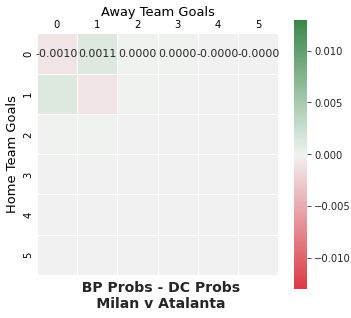

In [91]:
cmap = sns.diverging_palette(10, 133, as_cmap=True)

fig, ax = plt.subplots(figsize=(5,5))    
with sns.axes_style("white"):
    ax = sns.heatmap(simulate_match(poisson_model, 'Milan', 'Atalanta', max_goals=5) - \
                     dixon_coles_simulate_match(params, 'Milan', 'Atalanta', max_goals=5), 
                     annot=True, fmt='.4f', cmap=cmap, vmin=-0.013, vmax=.013, center=0.00,
                     square=True, linewidths=.5, annot_kws={"size": 11}, cbar_kws={"shrink": .8})
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.grid(which='major', axis='both', linestyle='')
    ax.set_xlabel('Away Team Goals', fontsize=13)
    ax.set_ylabel('Home Team Goals', fontsize=13)
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticks_position('top')
    plt.figtext(0.45, 0.07, '  BP Probs - DC Probs \n     Milan v Atalanta', horizontalalignment='center',
                fontsize=14, multialignment='left', fontweight='bold')
plt.tight_layout()
plt.show()

### Heatmap Visualization

- The heatmap compares the probabilities of different match outcomes (number of goals scored by each team) as predicted by the Basic Poisson model and the Dixon-Coles model. It subtracts the DC model probabilities from the BP model probabilities for each possible scoreline.
- The colors in the heatmap indicate the direction and magnitude of this difference:
  - **<font color="red">Reddish Squares</font>**: Indicate outcomes where the BP model predicted a higher probability than the DC model. In this case, the 0-0 and 1-1 outcomes are slightly red, meaning the BP model overestimated the likelihood of these low-scoring draws compared to the DC model.
  - **<font color="green">Greenish Squares**: Indicate outcomes where the DC model predicted a higher probability than the BP model. The 0-1 and 1-0 outcomes are slightly green, meaning the DC model gives these one-goal margin outcomes a slightly higher probability than the BP model.

In one way, this is a good plot. The correction was only intended to have an effect on 4 specific match results (0-0, 1-0, 0-1 and 1-1) and that's what has happened. On the other hand, that was alot of hard work to essentially tweak the existing model. And that's without even considering whether it was a beneficial adjustment. Without exploring that point any further, I'm going to discuss the second advancement introduced by the DC model.

## Dixon-Coles Time Decay Model

In the 2022/23 English Premier League season, Crystal Palace had a rough start, losing their first seven games, during which they didn't score any goals and conceded 17. This dismal performance was attributed to Ronald De Boer's attempt to shift the team towards a more possession-oriented style of play. However, after Roy Hodgson took over as manager, the team reverted to its traditional counter-attacking approach. This change helped Crystal Palace recover from their poor start, finishing the season in 11th place, a respectable position considering their early struggles.

When predicting the outcome of a Crystal Palace match in January 2018, it makes sense to lessen the impact of those early-season losses from August and September 2017. This is where incorporating a time component into the adjusted Poisson model becomes valuable. The challenging aspect is determining the best method to reduce the influence of those earlier games. The Dixon-Coles paper proposes two specific methods for adjusting the weighting of past matches.

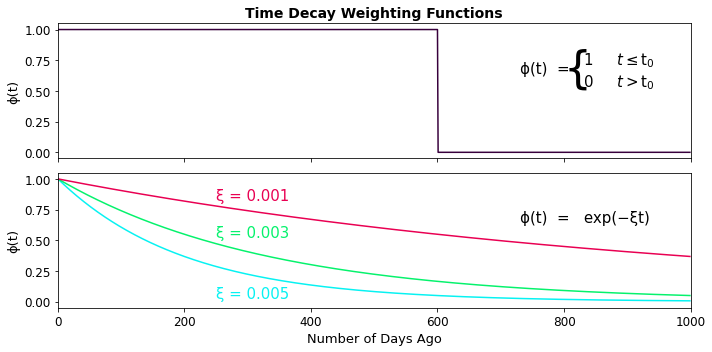

In [96]:
fig,(ax1,ax2) = plt.subplots(2, 1, figsize=(10,5))

ax1.plot(range(1000), [0 if y >600 else 1 for y in range(1000)], label='Step Function Component', color='#38003c', marker='')
ax2.plot(range(1000), np.exp([y*-0.005 for y in range(1000)]), label='Exponential Decay Component 1', color='#07F2F2', marker='')
ax2.plot(range(1000), np.exp([y*-0.003 for y in range(1000)]), label='Exponential Decay Component 2', color='#05F26C', marker='')
ax2.plot(range(1000), np.exp([y*-0.001 for y in range(1000)]), label='Exponential Decay Component 3', color='#e90052', marker='')

ax1.set_ylim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax1.set_xlim([-0.5,1000])
ax2.set_xlim([-0.5,1000])
ax1.set_xticklabels([])
ax2.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=12)
ax1.set_title("Time Decay Weighting Functions",size=14,fontweight='bold')
ax2.set_xlabel("Number of Days Ago",size=13)
ax1.set_ylabel("ϕ(t)",size=13)
ax2.set_ylabel("ϕ(t)",size=13)
ax1.text(830, 0.5, '1     $t \leq \mathregular{t_0}$\n0     $t > \mathregular{t_0}$',
        verticalalignment='bottom', horizontalalignment='left',
        color='black', fontsize=15)
ax1.text(800, 0.5, '{',
        verticalalignment='bottom', horizontalalignment='left',
        color='black', fontsize=44)
ax1.text(730, 0.62, 'ϕ(t)  = ',
        verticalalignment='bottom', horizontalalignment='left',
        color='black', fontsize=15)
ax2.text(730, 0.62, 'ϕ(t)  =   exp(−ξt)',
        verticalalignment='bottom', horizontalalignment='left',
        color='black', fontsize=15)
ax2.text(250, 0.8, 'ξ = 0.001',
        verticalalignment='bottom', horizontalalignment='left',
        color='#e90052', fontsize=15)
ax2.text(250, 0.5, 'ξ = 0.003',
        verticalalignment='bottom', horizontalalignment='left',
        color='#05F26C', fontsize=15)
ax2.text(250, 0.0, 'ξ = 0.005',
        verticalalignment='bottom', horizontalalignment='left',
        color='#07F2F2', fontsize=15)
plt.tight_layout()
plt.show()

### Plotting on the First Subplot: Step Function (`ax1`)

- The first plot shows a step function that is 1 for `t <= 600` and 0 for `t > 600`. This might represent a scenario where an event has full impact for the first 600 units of time and no impact thereafter.
- `ax1.plot(range(1000), [0 if y >600 else 1 for y in range(1000)], label='Component 1', color='#38003c', marker='')` plots this step function across a range of 0 to 999 on the x-axis.

### Plotting on the Second Subplot: Exponential Decay Function (`ax2`)

- The second subplot displays three exponential decay functions with different decay rates (`ξ = 0.005`, `0.003`, and `0.001`). These functions model how the impact of an event decreases exponentially over time.
- Three `ax2.plot(...)` calls draw these exponential functions using different colors to distinguish between the decay rates.

The Dixon-Coles model introduces two main approaches for adjusting the weight of past matches, enhancing prediction accuracy:

1. **Fixed Time Window Approach:** This method considers only the matches within a predefined period, such as the current season.
2. **Negative Exponential Weighting:** This approach applies a decreasing weight to matches based on how far back in time they occurred, using a negative exponential function to discount the influence of older matches more heavily.

## Mathematical Model

The refined model incorporates a time-dependent weighting factor to adjust the influence of past matches, defined as follows:

$$
L(\alpha_i, \beta_i, \rho, \gamma, i=1,\dots,n) = \prod_{k \in A_t}\left\{\tau_{\lambda_k,\mu_k}(x_k, y_k) \frac{e^{-\lambda} \lambda^{x_k} }{x_k!} \frac{e^{-\mu} \mu^{y_k} }{y_k!}\right\}^{\phi(t-t_k)}
$$

Where:
- $t_k$ is the time when match $k$ was played.
- $A_t = \{k: t_k < t\}$ represents the set of matches played before time $t$.
- $\alpha$, $\beta$, and $\gamma$ are parameters as defined in the original model.
- $\tau$ adjusts for the interaction between attacking and defensive strengths.
- $\phi$ is a non-increasing function that weights matches based on the time elapsed since they were played. Per the Dixon-Coles paper, $\phi(t)$ is set as a negative exponential function with rate $\xi$, which controls how past matches are weighted.

## Parameter Estimation

Optimizing this model involves fixing $\xi$ and estimating the remaining parameters to maximize the likelihood function. Directly maximizing the likelihood can be impractical for various reasons, including the ease of trivial maximization by simply increasing $\xi$. Therefore, we use a log-likelihood function, benefiting from the property that $\log(a^b) = b\log(a)$. When $\xi=0$, the model defaults to a standard non-time-weighted log-likelihood function.

In [27]:
def dc_log_like_decay(x, y, alpha_x, beta_x, alpha_y, beta_y, rho, gamma, t, xi=0):
    lambda_x, mu_y = np.exp(alpha_x + beta_y + gamma), np.exp(alpha_y + beta_x) 
    return  np.exp(-xi*t) * (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) + 
                              np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))

## Optimizing the Time Decay Parameter $(\xi)$

The goal is to identify the optimal value of $(\xi)$ that enhances the predictive accuracy of the model, focusing on the actual match results rather than just the scores. The model's effectiveness is measured by its ability to predict match outcomes (home win, draw, away win) with the highest probability.

### Methodology

To achieve this, we employ a criterion that assesses predictions based on the likelihood of the observed match outcomes. This is formalized as maximizing the sum $(S(\xi))$:

$$
S(\xi) = \sum^{N}_{k=1} (\delta^{H}_{k} \log p^{H}_{k} + \delta^{A}_{k} \log p^{A}_{k} + \delta^{D}_{k} \log p^{D}_{k})
$$

In this equation:
- $(\delta^{H}_{k}, \delta^{A}_{k}, \delta^{D}_{k})$ indicate whether the match $(k)$ resulted in a home win, away win, or draw, respectively (1 if true, 0 otherwise).
- $(p^{H}_{k}, p^{A}_{k}, p^{D}_{k})$ represent the probabilities of each match outcome (home win, away win, draw).

For instance, the probability of a home win ($(p^{H}_{k})$) is calculated as the sum of probabilities for all score combinations where the home team scores more than the away team:

$$
p^{H}_{k} = \sum_{l,m \in B_H} P(X_k = l, Y_k = m), \text{where } B_H = \{(l,m): l>m\}
$$

### Predictive Accuracy Assessment

To assess the model's accuracy:
1. A validation set approach is used, analogous to machine learning, selecting fixtures (e.g., on the 13th January 2023) and predicting their outcomes based on all prior season results.
2. The model is updated and reassessed for each subsequent set of fixtures, including newly played matches in the model's data.
3. This iterative process is repeated throughout the season, summing up the predictions to calculate the predicted profile log-likelihood for the given $(\xi)$.

### Computational Efficiency

To expedite computations:
1. Focus is placed on predicting fixtures in the last 100 days of the 2022/23 Serie A season to avoid unreliable early-season predictions.
2. Match days are grouped into sets of three consecutive days to minimize the frequency of model updates, considering the typical scheduling of matches.

We need to make some slight adjustments to the `sa_2223` dataframe to include columns that represent the number of days since the completion of that fixture as well as the match result (home, away or draw).

In [28]:
sa_2223 = pd.read_csv("https://www.football-data.co.uk/mmz4281/2223/I1.csv")
sa_2223['Date'] = pd.to_datetime(sa_2223['Date'],  format='%d/%m/%Y')
sa_2223['time_diff'] = (max(sa_2223['Date']) - sa_2223['Date']).dt.days
sa_2223 = sa_2223[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR', 'time_diff']]
sa_2223 = sa_2223.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
sa_2223.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,FTR,time_diff
0,Milan,Udinese,4,2,H,295
1,Sampdoria,Atalanta,0,2,A,295
2,Lecce,Inter,1,2,A,295
3,Monza,Torino,1,2,A,295
4,Fiorentina,Cremonese,3,2,H,294


The code calculates the `time_diff` column, representing the number of days between each match date and the most recent match in the dataset. This is useful for analyses that consider how recent a match is.

- The DataFrame is then filtered to include only the columns of interest (`HomeTeam`, `AwayTeam`, `HomeGoals`, `AwayGoals`, `FTR`, and `time_diff`) and renames `FTHG` and `FTAG` to `HomeGoals` and `AwayGoals`, respectively, for clarity.

With this dataframe, we're now ready to compare different values of $\xi$. To speed up this process even further, I made the code parallelisable and ran it across my computer's multiple (4) cores (see [Python file](https://github.com/dashee87/blogScripts/blob/master/Python/2018-09-13-dixon-coles-and-time-weighting/dixon_coles_decay_xi_1season.py)).

Here's an example of how you would build a model for a given value of $\xi$.

In [34]:
def solve_parameters_decay(dataset, xi=0.001, debug = False, init_vals=None, options={'disp': True, 'maxiter':100},
                     constraints = [{'type':'eq', 'fun': lambda x: sum(x[:20])-20}] , **kwargs):
    teams = np.sort(dataset['HomeTeam'].unique())
    # check for no weirdness in dataset
    away_teams = np.sort(dataset['AwayTeam'].unique())
    if not np.array_equal(teams, away_teams):
        raise ValueError("something not right")
    n_teams = len(teams)
    if init_vals is None:
        # random initialisation of model parameters
        init_vals = np.concatenate((np.random.uniform(0,1,(n_teams)), # attack strength
                                      np.random.uniform(0,-1,(n_teams)), # defence strength
                                      np.array([0,1.0]) # rho (score correction), gamma (home advantage)
                                     ))
        
    def dc_log_like_decay(x, y, alpha_x, beta_x, alpha_y, beta_y, rho, gamma, t, xi=xi):
        lambda_x, mu_y = np.exp(alpha_x + beta_y + gamma), np.exp(alpha_y + beta_x) 
        return  np.exp(-xi*t) * (np.log(rho_correction(x, y, lambda_x, mu_y, rho)) + 
                                  np.log(poisson.pmf(x, lambda_x)) + np.log(poisson.pmf(y, mu_y)))

    def estimate_paramters(params):
        score_coefs = dict(zip(teams, params[:n_teams]))
        defend_coefs = dict(zip(teams, params[n_teams:(2*n_teams)]))
        rho, gamma = params[-2:]
        log_like = [dc_log_like_decay(row.HomeGoals, row.AwayGoals, score_coefs[row.HomeTeam], defend_coefs[row.HomeTeam],
                                      score_coefs[row.AwayTeam], defend_coefs[row.AwayTeam], 
                                      rho, gamma, row.time_diff, xi=xi) for row in dataset.itertuples()]
        return -sum(log_like)
    opt_output = minimize(estimate_paramters, init_vals, options=options, constraints = constraints)
    if debug:
        # sort of hacky way to investigate the output of the optimisation process
        return opt_output
    else:
        return dict(zip(["attack_"+team for team in teams] + 
                        ["defence_"+team for team in teams] +
                        ['rho', 'home_adv'],
                        opt_output.x)) 

In [8]:
params_xi= solve_parameters_decay(sa_2223, xi=0.0018)

NameError: name 'rho_correction' is not defined

In [9]:
params_xi

NameError: name 'params_xi' is not defined

This Python code is designed to evaluate the performance of a time-decaying football match prediction model across different values of the decay parameter, `xi`. It aims to find the optimal `xi` value that maximizes the predictive accuracy of the model over a dataset containing Serie A matches for the 2022/2023 season. The code performs the following steps:

In [33]:
def get_1x2_probs(match_score_matrix):
    return dict({"H":np.sum(np.tril(match_score_matrix, -1)), 
                 "A":np.sum(np.triu(match_score_matrix, 1)), "D":np.sum(np.diag(match_score_matrix))})
    
# Wrap np.log calls to handle 0 or negative inputs safely
def safe_log(x):
    return np.log(x + 1e-10)  # Adding a small constant to avoid log(0)

def build_temp_model(dataset, time_diff, xi=0.000, init_params=None):
    test_dataset = dataset[((dataset['time_diff']<=time_diff) & (dataset['time_diff']>=(time_diff-2)))]
    if len(test_dataset)==0:
        return 0
    train_dataset = dataset[dataset['time_diff']>time_diff]
    train_dataset = train_dataset.copy()
    train_dataset.loc[:, 'time_diff'] = train_dataset['time_diff'] - time_diff

    params = solve_parameters_decay(train_dataset, xi=xi, init_vals=init_params)
    predictive_score = sum([safe_log(get_1x2_probs(dixon_coles_simulate_match(
                    params, row.HomeTeam, row.AwayTeam))[row.FTR]) for row in test_dataset.itertuples()])
    return predictive_score    

def get_total_score_xi(xi):
    xi_result = [build_temp_model(sa_2223, day, xi=xi) for day in range(99,-1,-3)]
    with open('find_xi_1season_{}.txt'.format(str(xi)[2:]), 'wb') as thefile:
        pickle.dump(xi_result, thefile)

### Defining Functions

2. **`get_1x2_probs` Function**:
   - Takes a match score matrix (a matrix of probabilities for all possible match outcomes) as input and calculates the probabilities of a home win (`H`), an away win (`A`), and a draw (`D`) by summing appropriate elements of the matrix.

3. **`build_temp_model` Function**:
   - Filters the dataset for matches occurring within a specified time window (`time_diff` ± 2 days) and separates it into a test dataset for evaluation and a training dataset for parameter optimization.
   - Adjusts the `time_diff` values in the training dataset to reflect the relative time from the evaluation point.
   - Optimizes model parameters using the `solve_parameters_decay` function, which includes the time decay effect governed by `xi`.
   - Calculates the predictive score for the test dataset using the optimized parameters and the actual match outcomes (`FTR`).

4. **`get_total_score_xi` Function**:
   - For a given `xi`, iterates over the dataset in steps of 3 days, building temporary models and aggregating their predictive scores.
   - Results for each `xi` value are saved to a file for later analysis.

In [35]:
sa_2223 = pd.read_csv("https://www.football-data.co.uk/mmz4281/2223/I1.csv")
sa_2223['Date'] = pd.to_datetime(sa_2223['Date'],  format='%d/%m/%Y')
sa_2223['time_diff'] = (max(sa_2223['Date']) - sa_2223['Date']).dt.days
sa_2223 = sa_2223[['HomeTeam','AwayTeam','FTHG','FTAG', 'FTR', 'time_diff']]
sa_2223 = sa_2223.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
sa_2223.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals,FTR,time_diff
0,Milan,Udinese,4,2,H,295
1,Sampdoria,Atalanta,0,2,A,295
2,Lecce,Inter,1,2,A,295
3,Monza,Torino,1,2,A,295
4,Fiorentina,Cremonese,3,2,H,294


### Preparing the Dataset

1. **Load and Process Data**:
   - The dataset is loaded from an online source containing match information for the Serie A 2022/2023 season.
   - The `Date` column is converted to datetime objects to calculate the `time_diff`, which represents the number of days between each match and the most recent match in the dataset.
   - The dataset is then filtered to include only relevant columns (`HomeTeam`, `AwayTeam`, `HomeGoals`, `AwayGoals`, `FTR`, and `time_diff`) and renames columns for clarity.

In [ ]:
if __name__ == '__main__':
    xi_vals = [0.0, 0.0002, 0.0004, 0.0006, 0.0008, 0.001, 0.0012, 0.0014, 0.0016, 0.0018, 
               0.002, 0.0025, 0.003, 0.0035, 0.0035, 0.004, 0.0045, 0.005]
    
    # Calculate total optimizations
    iterations_per_xi = len(range(99, -1, -3))  # This is how many days we are iterating over for each xi
    total_optimizations = len(xi_vals) * iterations_per_xi
    
    print("Starting pool...")
    print(f"Total optimizations needed: {total_optimizations}")
    with Pool(processes=8) as pool:         # start worker processes (number will depend on your computer's architecture)
        xi_result = pool.map(get_total_score_xi, xi_vals)
        

### Evaluating Different `xi` Values

5. **Main Execution**:
   - A list of `xi` values to test is defined, ranging from 0.0 (no time decay) to 0.005 (strong time decay).
   - The `Pool` object from the `multiprocessing` library is used to parallelize the evaluation process, speeding up the computation by utilizing multiple CPU cores. Each `xi` value is evaluated independently in parallel.
   - The `get_total_score_xi` function is called for each `xi` value, and the resulting scores are collected. This parallel execution is facilitated by `pool.map`.

### Objective

The overarching goal is to assess how the time decay parameter (`xi`) influences the model's ability to predict match outcomes accurately. By examining the predictive score across different `xi` values, the code aims to identify the optimal level of time sensitivity that should be incorporated into the model to enhance its predictive performance.

This approach recognizes that recent matches might be more indicative of a team's current form and therefore should have a greater influence on the prediction model. The optimal `xi` value helps balance the weight given to recent versus older matches, potentially improving the model's accuracy and relevance.

For the setup, considering `xi_values` with 18 different values and iterating over a range of days from 99 to 0 with a step of -3, there will be a total of **612 optimizations** performed.

In [1]:

# Calculating the total number of optimizations based on the given setup

# Number of xi values
xi_values_count = len([0.0, 0.0002, 0.0004, 0.0006, 0.0008, 0.001, 0.0012, 0.0014, 0.0016, 0.0018, 
               0.002, 0.0025, 0.003, 0.0035, 0.0035, 0.004, 0.0045, 0.005])

# Number of days being iterated over with a step of -3 from 99 to 0
days_count = len(range(99, -1, -3))

# Total number of optimizations is the product of the two
total_optimizations = xi_values_count * days_count

total_optimizations


612